# 客户画像复赛 数据处理 - 01表（工单信息）特征提取

In [1]:
!ls Data_Update/train/

01_arc_s_95598_wkst_train.tsv  06_cont_info.tsv		11_c_meter.tsv
02_s_comm_rec.tsv	       07_c_rca_cons.tsv	12_a_pay_flow.tsv
03_s_info_oversee.tsv	       08_a_rcved_flow.tsv	out
04_c_cons.tsv		       09_arc_a_rcvbl_flow.tsv	train_label.csv
05_c_cons_prc.tsv	       10_c_meter_read.tsv


## 1 导入必要的包和函数

In [1]:
%pdb 1
debug = 1
import pandas as pd
import numpy as np
import pickle
import re
import io 
import matplotlib.pyplot as plt
%matplotlib inline

# 加载预定义好的函数
# 预定义好的函数：
#    - load_data(file_name, header=0): 加载数据
#    - def show_attribute_detail( data=None, attribute_name=None): 显示数据某个属性的详情
%run data_util_func.py
# 选择过滤方案
PLAN_TYPE = 3

Automatic pdb calling has been turned ON


##  2 加载数据 

### 2-1 用户列表 和 工单数据

In [2]:
%store -r train_data01_merge_label_df test_data01_merge_label_df
%store -r train_data01_a_worker_per_user test_data01_a_worker_per_user

In [34]:
%who_ls

['FeatureEncoder',
 'data01_appno_contenttype_rdd',
 'data_feature_encoder',
 'debug',
 'extend_train_data',
 'get_accept_content_type',
 'get_highest_sensitive_workerid',
 'get_metrics',
 'io',
 'is_highest_sensitive_worker_dict',
 'load_data',
 'model_predict',
 'model_train',
 'np',
 'pd',
 'pickle',
 'plt',
 'print_function',
 're',
 'save_data',
 'seperate_data_to_classifier',
 'show_attribute_detail',
 'show_df_info',
 'test_data01_df',
 'test_data01_merge_label_df',
 'test_data_labels_df',
 'train_accept_content_type_count_df',
 'train_accept_content_type_sensitive_rate_series',
 'train_custno_in_season4_count_dict',
 'train_custno_in_season4_count_rdd',
 'train_custno_search_action_count_dict',
 'train_custno_search_action_count_rdd',
 'train_data01_a_worker_per_user',
 'train_data01_a_worker_per_user_accept_content_type_count_df',
 'train_data01_custno_handle_month_rdd',
 'train_data01_custno_issearchaction_rdd',
 'train_data01_merge_label_df',
 'train_data01_user_worker_count

## 3 进行不同特征的探索

### 3-1 统计每个用户的 工单数


#### 3-1-1 训练集

##### 3-1-1-1 统计每个用户的工单数

In [6]:
%%time
# 统计每个用户的工单数
train_data01_user_worker_count_series = train_data01_merge_label_df['CUST_NO'].value_counts()

CPU times: user 1.04 s, sys: 4 ms, total: 1.04 s
Wall time: 1.04 s


In [66]:
train_data01_user_worker_count_series['6010052424']

83

In [68]:
# 检验总用户数是不是这个数字
len(train_data01_user_worker_count_series) ==  658374

True

##### 3-1-1-2 添加一个字段 工单数

In [7]:
%%time
# 添加一个字段 工单数
train_data01_merge_label_df['NUM_OF_WORKER'] = \
    train_data01_merge_label_df['CUST_NO'].map(train_data01_user_worker_count_series)

CPU times: user 756 ms, sys: 0 ns, total: 756 ms
Wall time: 755 ms


In [24]:
# 取出  'NUM_OF_WORKER','CUST_NO','TAGG' 这三个字段进行 统计
temp = train_data01_merge_label_df[['NUM_OF_WORKER','CUST_NO','TAG']].drop_duplicates()
print temp.shape

(658377, 3)


工单数分布情况
(59, 5)
      total      tag0  tag0/total     tag1  tag1/total
61       61       0.0    0.000000     61.0    1.000000
37      259       0.0    0.000000    259.0    1.000000
66       66       0.0    0.000000     66.0    1.000000
29      464       0.0    0.000000    464.0    1.000000
39      195       0.0    0.000000    195.0    1.000000
41       41       0.0    0.000000     41.0    1.000000
42       42       0.0    0.000000     42.0    1.000000
83       83       0.0    0.000000     83.0    1.000000
47       94       0.0    0.000000     94.0    1.000000
50       50       0.0    0.000000     50.0    1.000000
71      213       0.0    0.000000    213.0    1.000000
70       70       0.0    0.000000     70.0    1.000000
53      106       0.0    0.000000    106.0    1.000000
60       60       0.0    0.000000     60.0    1.000000
26      494      26.0    0.052632    468.0    0.947368
22      748      44.0    0.058824    704.0    0.941176
33      396      33.0    0.083333    363.0    0.9

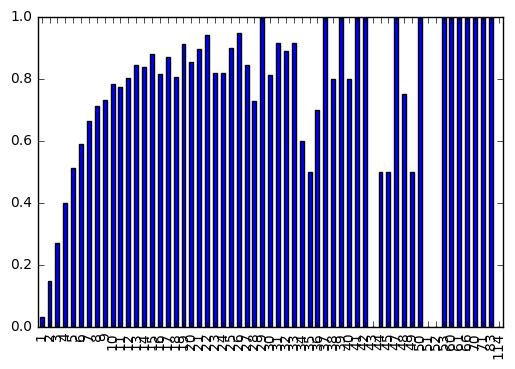

In [11]:
print '工单数分布情况'
temp = show_attribute_detail(train_data01_merge_label_df,
                      attribute_name='NUM_OF_WORKER',
                      split_by_tag=True,
                      tag_name='TAG').sort_values(by='tag1/total',ascending=False)
print temp

#### 3-1-2 测试集

##### 3-1-2-1 统计每个用户的工单数

In [37]:
%%time
# 统计每个用户的工单数
test_data01_user_worker_count_series = test_data01_merge_label_df['CUST_NO'].value_counts()

CPU times: user 392 ms, sys: 4 ms, total: 396 ms
Wall time: 393 ms


##### 3-1-2-2 添加一个字段 工单数

In [38]:
%%time
# 添加一个字段 工单数
test_data01_merge_label_df['NUM_OF_WORKER'] = \
    test_data01_merge_label_df['CUST_NO'].map(test_data01_user_worker_count_series)

CPU times: user 360 ms, sys: 4 ms, total: 364 ms
Wall time: 366 ms


#### 3-1-3 用户工单数初步结论
- 从训练集得出：工单数越多，敏感读越高，但是不是很明显


### 3-2 ACCEPT_CONTENT 工作单受理内容

#### 3-2-1 训练集

##### 3-2-1-1 增加字段 ACCEPT_CONTENT_TYPE

In [3]:
%%time
train_data01_merge_label_df['ACCEPT_CONTENT_TYPE'] = \
        train_data01_merge_label_df['ACCEPT_CONTENT'].apply(lambda x : get_accept_content_type(x,return_first1=True))
print train_data01_merge_label_df['ACCEPT_CONTENT_TYPE'][:5]

0    一户无电
1    银行代扣
2    查询电费
3    查询电费
4    查询电费
Name: ACCEPT_CONTENT_TYPE, dtype: object
CPU times: user 4.06 s, sys: 104 ms, total: 4.16 s
Wall time: 4.15 s


##### 3-3-1-2 统计 工单类型为空的 记录 的 敏感 /不敏感分布情况

(2,)


0    2155
1     570
Name: TAG, dtype: int64

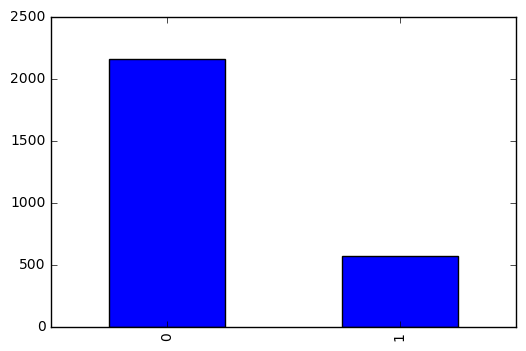

In [11]:
show_attribute_detail(
    train_data01_merge_label_df.loc[train_data01_merge_label_df['ACCEPT_CONTENT_TYPE'].isnull()],
    attribute_name='TAG',
)

##### 3-3-1-3 统计所有工单类别的敏感度（每个工单类别 tag1数量/总数）

In [10]:
# 在训练集上的所有工单上 统计
train_accept_content_type_count_df = show_attribute_detail(
    train_data01_merge_label_df,
    'ACCEPT_CONTENT_TYPE',
    split_by_tag=True, 
    tag_name='TAG',
    show_pic=False,
)
print train_accept_content_type_count_df.head()

# 取出敏感度统计量  tag1/total
train_accept_content_type_sensitive_rate_series = train_accept_content_type_count_df['tag1/total']


(1135, 5)
                total  tag0  tag0/total  tag1  tag1/total
2户无电                3   3.0         1.0   0.0         0.0
4404072760回呼电话      1   0.0         0.0   1.0         1.0
APP                 2   2.0         1.0   0.0         0.0
APP密码               1   1.0         1.0   0.0         0.0
app                 1   1.0         1.0   0.0         0.0


In [32]:
# 
save_data(
    train_accept_content_type_count_df,
    'train_accept_content_type_sensitive_rate_first1.csv',
    index=True
)

In [33]:
train_accept_content_type_sensitive_rate_series.get(u'4404072760回呼电话',0)

1.0

In [17]:
train_accept_content_type_count_df.shape

(1135, 5)

#### 3-3-2 测试集

##### 3-3-2-1 增加字段 ACCEPT_CONTENT_TYPE

In [4]:
%%time
test_data01_merge_label_df['ACCEPT_CONTENT_TYPE'] = \
        test_data01_merge_label_df['ACCEPT_CONTENT'].apply(lambda x : get_accept_content_type(x,return_first1=True))
print test_data01_merge_label_df['ACCEPT_CONTENT_TYPE'][:5]

0    客户咨询一户无电
1          退订
2        查询电费
3       咨询总户号
4        设备故障
Name: ACCEPT_CONTENT_TYPE, dtype: object
CPU times: user 1.67 s, sys: 4 ms, total: 1.67 s
Wall time: 1.67 s


In [19]:
show_attribute_detail(
    test_data01_merge_label_df,
    'ACCEPT_CONTENT_TYPE',
    show_pic=False
)

(664,)


2户无电                1
APP                 1
一户无电            27336
一户跳闸                4
一户频繁跳闸              3
三户无电                2
专业咨询               15
业务办理超时限             1
业务变更                7
业务超时                1
业扩变更              252
业扩报装              100
业扩报装加速              1
业扩超时               19
两户无电               13
中介                 11
中介咨询总户号            50
中介来电               92
中介查户号               3
中介查询电费              3
临时停电信息              1
临时用电                1
二户无电                1
交费售电网点             13
交费差错更正             19
交错费                 1
人员态度               46
人员违规               65
人身伤亡                2
代征电费                2
                ...  
错发短信               29
闪断                  2
阶梯电价             3057
青苗赔偿               29
非供企业维护              1
非供电业务             656
非供电业务咨询             1
非供电公司业务             1
非供电公司抢修范围           1
非供电公司维护范围          11
非供电维修               1
非南方供电业务             1
非家电设备损坏            11
非居民内部故障             8
非用电业务咨询   

#### 3-3-3 小结
- 在训练集所有工单上 总共 1,135 个 工单类型
- 在测试集所有工单上 总共   664 个 工单类型
- 回访类型相关的都敏感度不高，比如 网站回访等
- 跟电量相关的敏感度高点

### 3-3 用户查询次数

#### 3-4-1 训练集

##### 3-4-1-1 新增字段 IS_SEARCH_ACTION 标识 当前 小工单类型 是否 查询电费的动作

In [14]:
%%time
# 是 查询电费 ，则设置为1
train_data01_merge_label_df.loc[train_data01_merge_label_df['ACCEPT_CONTENT_TYPE'] == u'查询电费',
                                'IS_SEARCH_ACTION'] = 1
# 不是 查询电费 ，则设置为1
train_data01_merge_label_df.loc[train_data01_merge_label_df['IS_SEARCH_ACTION'].isnull(),'IS_SEARCH_ACTION']=0


CPU times: user 352 ms, sys: 36 ms, total: 388 ms
Wall time: 394 ms


In [56]:
train_data01_merge_label_df[train_data01_merge_label_df['CUST_NO']=='0002582056']

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,PROV_ORG_NO,CITY_ORG_NO,TAG,HANDLE_HOUR,HANDLE_YEAR,HANDLE_MONTH,HANDLE_DAY,ACCEPT_CONTENT_TYPE,IS_SEARCH_ACTION,NUM_OF_HANDLE_MONTH
544330,2015090474784841,1000000491321402,3,2.0,3340140,2015/9/4 12:14:50,【查询电费】客户查询9月是否欠费,NaN,1701598.0,200.0,...,33101,33401,0,12,2015,9,4,查询电费,1.0,2
901508,2015031446543827,1000000298302237,3,2.0,3340101,2015/3/14 16:35:03,【查询电费】客户查询是否欠费，欠费金额，已告知,NaN,1701598.0,200.0,...,33101,33401,0,16,2015,3,14,查询电费,1.0,2
921891,2015031847091845,1000000302024005,1,1.0,3340140,2015/3/18 13:36:23,【一户无电】低压居民客户报修一户无电，经指导客户检查，无法判断设备故障及其资产归属，请现场查处,NaN,1701598.0,NaN,...,33101,33401,0,13,2015,3,18,一户无电,0.0,2
921906,2015031847093472,1000000302032462,3,2.0,334014001,2015/3/18 13:44:50,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1701598.0,200.0,...,33101,33401,0,13,2015,3,18,客户咨询一户无电,0.0,2
930563,2015031346386197,1000000297252445,3,1.0,3340101,2015/3/13 12:44:00,【查询电费】客户查询电费相关信息，已告知。,NaN,1701598.0,NaN,...,33101,33401,0,12,2015,3,13,查询电费,1.0,2
933414,2015031346398822,1000000297335673,3,2.0,334014001,2015/3/13 14:13:34,【查询电费】客户查询电费，已告知,NaN,1701598.0,200.0,...,33101,33401,0,14,2015,3,13,查询电费,1.0,2


##### 3-4-1-2 统计 每个用户的查询电费次数

In [12]:
train_data01_custno_issearchaction_rdd = \
    sc.parallelize(train_data01_merge_label_df[['CUST_NO','IS_SEARCH_ACTION']].as_matrix())
train_data01_custno_issearchaction_rdd.cache()

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:475

In [13]:
%%time
train_custno_search_action_count_rdd = train_data01_custno_issearchaction_rdd.groupBy(lambda x:x[0]).mapValues(
    lambda items: sum([x[1] for x in items ])
)
train_custno_search_action_count_dict = train_custno_search_action_count_rdd.collectAsMap()

CPU times: user 456 ms, sys: 40 ms, total: 496 ms
Wall time: 26 s


In [19]:
len(train_custno_search_action_count_dict) == 658374

True

##### 3-4-1-3 新增字段 NUM_OF_SEARCH_ACTION 标识 用户 是否 查询电费的次数

In [14]:
train_data01_merge_label_df['NUM_OF_SEARCH_ACTION'] = \
    train_data01_merge_label_df['CUST_NO'].map(train_custno_search_action_count_dict)

In [26]:
train_data01_merge_label_df.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,CUST_NO,PROV_ORG_NO,CITY_ORG_NO,TAG,ACCEPT_CONTENT_TYPE,IS_SEARCH_ACTION,NUM_OF_SEARCH_ACTION
0,2015101280016584,1000000527201688,1,2.0,3340501,2015/10/12 7:27:08,【一户无电】非居民客户报修一户无电，经指导客户检查，无法判断设备故障及其资产归属，请现场查处。,NaN,1625671.0,405.0,5115500151,33101,33405,0,一户无电,0.0,0.0
1,2015101280016722,1000000527203612,3,2.0,3341020,2015/10/12 7:31:50,【银行代扣】客户咨询银行代扣事宜,NaN,1196922.0,202.0,5720017228,33101,33410,0,银行代扣,0.0,0.0
2,2015101280016734,1000000527203685,3,2.0,3340670,2015/10/12 7:32:03,【查询电费】客户查询本月电费金额，已告知。,NaN,1378624.0,201.0,6911007734,33101,33406,0,查询电费,1.0,3.0
3,2015101280019989,1000000527220221,3,1.0,3340401,2015/10/12 8:04:42,【查询电费】客户查询本月电费金额。,NaN,1149071.0,202.0,4400013050,33101,33404,1,查询电费,1.0,12.0
4,2015101280020073,1000000527220797,3,1.0,334010101,2015/10/12 8:06:05,【查询电费】客户查询电费是否欠费，已告知。,NaN,1052032.0,100.0,6023002461,33101,33401,1,查询电费,1.0,31.0


##### 3-4-1-4 分布情况

查询电费的次数
(51, 5)
       total      tag0  tag0/total   tag1  tag1/total
25.0     336       0.0    0.000000    336    1.000000
42.0      95       0.0    0.000000     95    1.000000
34.0     110       0.0    0.000000    110    1.000000
36.0      81       0.0    0.000000     81    1.000000
37.0     109       0.0    0.000000    109    1.000000
38.0     128       0.0    0.000000    128    1.000000
39.0      40       0.0    0.000000     40    1.000000
40.0      44       0.0    0.000000     44    1.000000
45.0     102       0.0    0.000000    102    1.000000
26.0     151       0.0    0.000000    151    1.000000
48.0      71       0.0    0.000000     71    1.000000
50.0     103       0.0    0.000000    103    1.000000
60.0      70       0.0    0.000000     70    1.000000
61.0      61       0.0    0.000000     61    1.000000
64.0      66       0.0    0.000000     66    1.000000
68.0      71       0.0    0.000000     71    1.000000
29.0      65       0.0    0.000000     65    1.000000
75.0      83

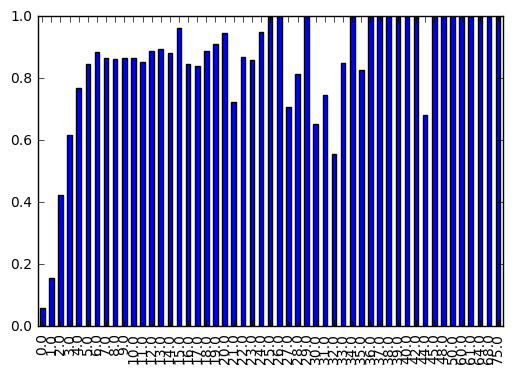

In [43]:
print '查询电费的次数'
train_data01_merge_label_num_of_search_action_count_df = show_attribute_detail(train_data01_merge_label_df,
                      attribute_name='NUM_OF_SEARCH_ACTION',
                      split_by_tag=True,
                      tag_name='TAG').sort_values(by='tag1/total',ascending=False)
print train_data01_merge_label_num_of_search_action_count_df

##### 添加字段  用户 最高 月[查询电费]的数量

In [39]:
%%time
def get_max_num_of_search_action(x):
#     用户月最大查询电费次数
    result = max(x.groupby('HANDLE_MONTH')['IS_SEARCH_ACTION'].apply(lambda x:sum(x)))
    return pd.Series(result)


train_data01_cust_no_max_num_of_search_action_df = \
    train_data01_merge_label_df.groupby('CUST_NO')['HANDLE_MONTH','IS_SEARCH_ACTION'].apply(get_max_num_of_search_action)

CPU times: user 11min 59s, sys: 3.48 s, total: 12min 2s
Wall time: 12min 2s


In [61]:
train_data01_cust_no_max_num_of_search_action_dict = \
    train_data01_cust_no_max_num_of_search_action_df[0].to_dict()

In [66]:
train_data01_a_worker_per_user['MAX_NUM_MONTH_SEARCH_ACTION'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data01_cust_no_max_num_of_search_action_dict)

(18, 5)


,total,tag0,tag0/total,tag1,tag1/total
0.0,377156,362534.0,0.961231,14622,0.038769
1.0,234882,199186.0,0.848026,35696,0.151974
2.0,36480,14833.0,0.406606,21647,0.593394
3.0,7196,1516.0,0.210673,5680,0.789327
4.0,1797,211.0,0.117418,1586,0.882582
5.0,542,45.0,0.083026,497,0.916974
6.0,171,12.0,0.070175,159,0.929825
7.0,74,7.0,0.094595,67,0.905405
8.0,37,2.0,0.054054,35,0.945946
9.0,18,2.0,0.111111,16,0.888889


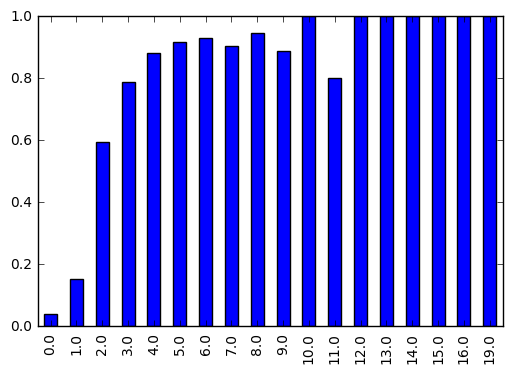

In [4]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'MAX_NUM_MONTH_SEARCH_ACTION',
    True,
    'TAG'
)

(51, 5)


,total,tag0,tag0/total,tag1,tag1/total
0.0,377156,362534.0,0.961231,14622,0.038769
1.0,195872,174487.0,0.890822,21385,0.109178
2.0,50712,30836.0,0.608061,19876,0.391939
3.0,17657,7241.0,0.410092,10416,0.589908
4.0,7522,1888.0,0.250997,5634,0.749003
5.0,3488,578.0,0.165711,2910,0.834289
6.0,1809,226.0,0.124931,1583,0.875069
7.0,1124,163.0,0.145018,961,0.854982
8.0,651,93.0,0.142857,558,0.857143
9.0,509,69.0,0.135560,440,0.864440


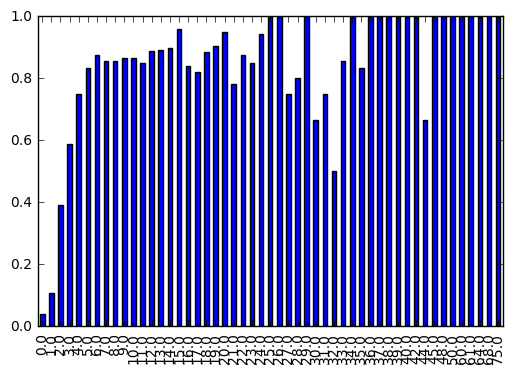

In [5]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'NUM_OF_SEARCH_ACTION',
    True,
    'TAG'
)

#### 3-4-2 测试集

##### 3-4-2-1 新增字段 IS_SEARCH_ACTION 标识 当前 小工单类型 是否 查询电费的动作

In [74]:
%%time
# 是 查询电费 ，则设置为1
test_data01_merge_label_df.loc[test_data01_merge_label_df['ACCEPT_CONTENT_TYPE'] == u'查询电费',
                                'IS_SEARCH_ACTION'] = 1
# 不是 查询电费 ，则设置为1
test_data01_merge_label_df.loc[test_data01_merge_label_df['IS_SEARCH_ACTION'].isnull(),'IS_SEARCH_ACTION']=0


CPU times: user 156 ms, sys: 4 ms, total: 160 ms
Wall time: 160 ms


##### 3-4-2-2 统计 每个用户的查询电费次数

In [41]:
test_data01_custno_issearchaction_rdd = \
    sc.parallelize(test_data01_merge_label_df[['CUST_NO','IS_SEARCH_ACTION']].as_matrix())
test_data01_custno_issearchaction_rdd.cache()

ParallelCollectionRDD[18] at parallelize at PythonRDD.scala:475

In [42]:
%%time
test_custno_search_action_count_rdd = test_data01_custno_issearchaction_rdd.groupBy(lambda x:x[0]).mapValues(
    lambda items: sum([x[1] for x in items ])
)
test_custno_search_action_count_dict = test_custno_search_action_count_rdd.collectAsMap()

CPU times: user 248 ms, sys: 36 ms, total: 284 ms
Wall time: 8.46 s


In [39]:
len(test_custno_search_action_count_dict) == 370871

True

##### 3-4-2-3 新增字段 NUM_OF_SEARCH_ACTION 标识 用户 是否 查询电费的次数

In [43]:
test_data01_merge_label_df['NUM_OF_SEARCH_ACTION'] = \
    test_data01_merge_label_df['CUST_NO'].map(test_custno_search_action_count_dict)

In [41]:
test_data01_merge_label_df.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,CUST_NO,PROV_ORG_NO,CITY_ORG_NO,ACCEPT_CONTENT_TYPE,IS_SEARCH_ACTION,NUM_OF_SEARCH_ACTION
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,9400029736,33101,33407,客户咨询一户无电,0.0,0.0
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,6851831254,33101,33406,退订,0.0,0.0
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,7312218251,33101,33406,查询电费,1.0,1.0
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,3330149860,33101,33408,咨询总户号,0.0,0.0
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,5210210735,33101,33405,设备故障,0.0,0.0


##### 3-4-2-4 分布情况

查询电费的次数
(9,)
0.0    269135
1.0    130555
2.0     19173
3.0      3753
4.0       835
5.0       219
6.0        19
7.0        29
9.0        10
Name: NUM_OF_SEARCH_ACTION, dtype: int64


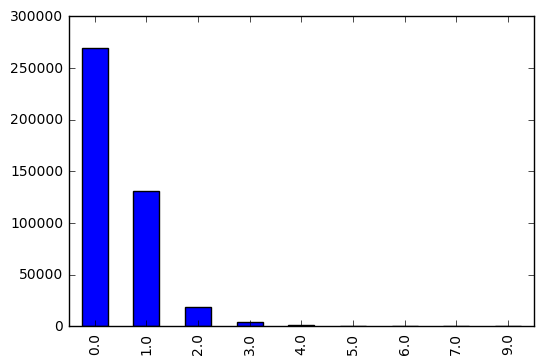

In [25]:
print '查询电费的次数'
test_data01_merge_label_num_of_search_action_count_df = show_attribute_detail(test_data01_merge_label_df,
                      attribute_name='NUM_OF_SEARCH_ACTION',
                      )
print test_data01_merge_label_num_of_search_action_count_df

##### 添加字段  用户 最高 月[查询电费]的数量

In [92]:
%%time
def get_max_num_of_search_action(x):
#     用户月最大查询电费次数
    result = max(x.groupby('HANDLE_MONTH').apply(lambda y:sum(y['IS_SEARCH_ACTION'])))
    return result


test_data01_cust_no_max_num_of_search_action_df = \
    test_data01_merge_label_df.groupby('CUST_NO').apply(get_max_num_of_search_action)

CPU times: user 13min 31s, sys: 3.59 s, total: 13min 35s
Wall time: 13min 55s


In [83]:
test_data01_cust_no_max_num_of_search_action_dict = \
    test_data01_cust_no_max_num_of_search_action_df[0].to_dict()

In [84]:
test_data01_a_worker_per_user['MAX_NUM_MONTH_SEARCH_ACTION'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data01_cust_no_max_num_of_search_action_dict)

(6,)


0.0    246199
1.0    119977
2.0      4382
3.0       284
4.0        27
5.0         2
Name: MAX_NUM_MONTH_SEARCH_ACTION, dtype: int64

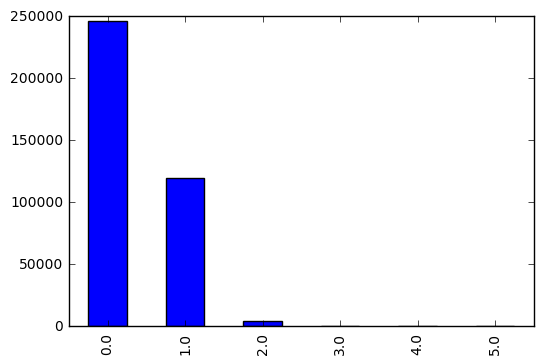

In [88]:
show_attribute_detail(
    test_data01_a_worker_per_user,
    'MAX_NUM_MONTH_SEARCH_ACTION'
)

#### 3-4-3 合并结果

In [45]:
temp = train_data01_merge_label_num_of_search_action_count_df.join(
    test_data01_merge_label_num_of_search_action_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['NUM_OF_SEARCH_ACTION']
temp = temp.drop(labels = [u'NUM_OF_SEARCH_ACTION'],axis=1)
temp

,total,tag0,tag0/total,tag1,tag1/total,test_total
25.0,336,0.0,0.000000,336,1.000000,0.0
42.0,95,0.0,0.000000,95,1.000000,0.0
34.0,110,0.0,0.000000,110,1.000000,0.0
36.0,81,0.0,0.000000,81,1.000000,0.0
37.0,109,0.0,0.000000,109,1.000000,0.0
38.0,128,0.0,0.000000,128,1.000000,0.0
39.0,40,0.0,0.000000,40,1.000000,0.0
40.0,44,0.0,0.000000,44,1.000000,0.0
45.0,102,0.0,0.000000,102,1.000000,0.0
26.0,151,0.0,0.000000,151,1.000000,0.0


### 3-4 代表工单(每个用户只取敏感度最高的订单作为代表工单) &&  添加新字段- ACCEPT_CONTENT_TYPE 的统计情况 添加到代表工单中

#### 3-5-1 训练集

#### 3-5-1-1 添加字段 IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE 是否高敏感工单类型 的工单

In [20]:
%%time
# 新增字段 - 是否高敏感工单
data01_appno_contenttype_rdd = \
    sc.parallelize(train_data01_merge_label_df[['APP_NO','CUST_NO','ACCEPT_CONTENT_TYPE']].as_matrix())
     
user_highest_sensitive_worker_rdd = \
        data01_appno_contenttype_rdd.groupBy(lambda x : x[1]).mapValues(
                                lambda x : get_highest_sensitive_workerid(x,
                                                                          train_accept_content_type_sensitive_rate_series))

user_highest_sensitive_worker_dict = user_highest_sensitive_worker_rdd.collectAsMap()

# 新增字段 - 是否高敏感工单
is_highest_sensitive_worker_dict = {i:1 for i in user_highest_sensitive_worker_dict.values()}

train_data01_merge_label_df['IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE'] = \
        train_data01_merge_label_df['APP_NO'].map(is_highest_sensitive_worker_dict)

CPU times: user 3.04 s, sys: 512 ms, total: 3.56 s
Wall time: 31.5 s


##### 3-5-1-2 生成代表工单 train_data01_a_worker_per_user

In [21]:
# data01数据的 只留下 每个用户一条最高敏感工单，剩下 658,377条
train_data01_a_worker_per_user = \
    train_data01_merge_label_df.loc[train_data01_merge_label_df['IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE'].notnull()]
train_data01_a_worker_per_user.shape

(658374, 24)

In [39]:
len(train_data01_a_worker_per_user['CUST_NO'].unique()) == 658377

True

In [18]:
show_df_info(train_data01_a_worker_per_user)

              APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
1   2015101280016722  1000000527203612               3               2.0   
6   2015101280031388  1000000527304861               3               1.0   
8   2015101280031680  1000000527300870               3               2.0   
12  2015101280032506  1000000527305664               3               1.0   
13  2015101280032529  1000000527305820               3               2.0   

       ORG_NO         HANDLE_TIME                ACCEPT_CONTENT  \
1     3341020  2015/10/12 7:31:50              【银行代扣】客户咨询银行代扣事宜   
6     3340901  2015/10/12 9:14:03  【咨询总户号】通过地址（户名、表号）查询户号信息，已告知   
8   334020106  2015/10/12 9:11:37        【咨询总户号】通过地址（户名）查询户号信息。   
12    3340101  2015/10/12 9:14:48  【咨询总户号】通过地址（户名、表号）查询户号信息，已告知   
13  334104001  2015/10/12 9:14:58                  【咨询总户号】中介查户号   

   HANDLE_OPINION  CALLING_NO  ELEC_TYPE     CUST_NO  PROV_ORG_NO  \
1             NaN   1196922.0      202.0  5720017228        33101   
6 

(2,)


0    578352
1     80025
Name: TAG, dtype: int64

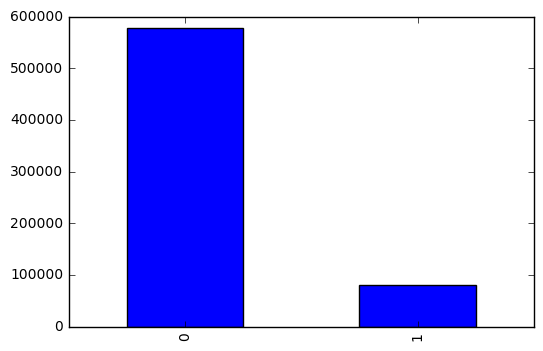

In [67]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'TAG'
)

##### 3-5-1-3 统计 代表工单 上工单类别的情况

###### 统计 代表工单 上所有工单类别的情况

In [4]:
# 训练集 代表工单 ACCEPT_CONTENT_TYPE
# 有799条工单类型
train_data01_a_worker_per_user_accept_content_type_count_df = show_attribute_detail(
    train_data01_a_worker_per_user,
    'ACCEPT_CONTENT_TYPE',
    split_by_tag=True, 
    tag_name='TAG',
    show_pic=False,
)

(799, 5)


###### 统计 经过09表规则 过滤之后的 代表工单 上所有工单类别的情况

In [30]:
# 训练集 代表工单 ACCEPT_CONTENT_TYPE
# 有749条工单类型
train_data01_a_worker_per_user_after09table_accept_content_type_count_df = show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'ACCEPT_CONTENT_TYPE',
    split_by_tag=True, 
    tag_name='TAG',
    show_pic=False,
)

(749, 5)


###### 空工单类型的 用户情况

(2,)


0    495
1     71
Name: TAG, dtype: int64

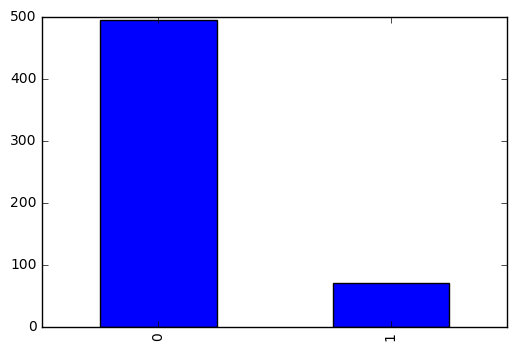

In [31]:
# 有715个记录无工单类型
show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['ACCEPT_CONTENT_TYPE'].isnull()],
    'TAG',
)

In [29]:
save_data(
    train_data01_a_worker_per_user_accept_content_type_count_df,
    'train_accept_content_type_first1.csv',
    index=True
)

#### 3-5-2 测试集

##### 3-5-2-1 添加字段 IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE 是否高敏感工单类型 的工单

In [48]:
%%time
# 新增字段 - 是否高敏感工单
data01_appno_contenttype_rdd = \
    sc.parallelize(test_data01_merge_label_df[['APP_NO','CUST_NO','ACCEPT_CONTENT_TYPE']].as_matrix())
     
user_highest_sensitive_worker_rdd = \
        data01_appno_contenttype_rdd.groupBy(lambda x : x[1]).mapValues(
                                lambda x : get_highest_sensitive_workerid(x,
                                                                          train_accept_content_type_sensitive_rate_series))
# is_leave = []
user_highest_sensitive_worker_dict = user_highest_sensitive_worker_rdd.collectAsMap()

# 新增字段 - 是否高敏感工单
is_highest_sensitive_worker_dict = {i:1 for i in user_highest_sensitive_worker_dict.values()}

test_data01_merge_label_df['IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE'] = \
        test_data01_merge_label_df['APP_NO'].map(is_highest_sensitive_worker_dict)

CPU times: user 1.51 s, sys: 176 ms, total: 1.68 s
Wall time: 13 s


##### 3-5-2-2 生成代表工单 test_data01_a_worker_per_user

In [49]:
# data01数据的 只留下 每个用户一条最高敏感工单，剩下 370,871条
test_data01_a_worker_per_user = \
    test_data01_merge_label_df.loc[test_data01_merge_label_df['IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE'].notnull()]
test_data01_a_worker_per_user.shape

(370871, 23)

In [40]:
test_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,CUST_NO,PROV_ORG_NO,CITY_ORG_NO,ACCEPT_CONTENT_TYPE,IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE,HANDLE_HOUR,HANDLE_YEAR,HANDLE_MONTH,HANDLE_DAY
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,9400029736,33101,33407,客户咨询一户无电,1.0,7,2015,10,12
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,6851831254,33101,33406,退订,1.0,7,2015,10,12
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,7312218251,33101,33406,查询电费,1.0,7,2015,10,12
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,3330149860,33101,33408,咨询总户号,1.0,8,2015,10,12
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,5210210735,33101,33405,设备故障,1.0,8,2015,10,12


##### 3-5-2-3 统计 代表工单 上所有工单类别的情况

###### 统计 代表工单 上所有工单类别的情况

In [38]:
# 无工单类型用户数量有 578 个
test_data01_a_worker_per_user[test_data01_a_worker_per_user['ACCEPT_CONTENT_TYPE'].isnull()].shape

(353, 30)

In [35]:
# 测试集 代表工单 有工单类型 ACCEPT_CONTENT_TYPE 的统计情况
# 总共有 591 个工单类型
test_data01_a_worker_per_user_accept_content_type_count_df = show_attribute_detail(
    test_data01_a_worker_per_user,
    'ACCEPT_CONTENT_TYPE',
    show_pic=False,
)

(450,)


###### 统计 经过09表规则 过滤之后的 代表工单 上所有工单类别的情况

In [31]:
# 测试集 代表工单 ACCEPT_CONTENT_TYPE
# 有450条工单类型

test_data01_a_worker_per_user_after09table_accept_content_type_count_df = show_attribute_detail(
    test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'ACCEPT_CONTENT_TYPE',
    show_pic=False,
)

(450,)


###### 保存

In [34]:
save_data(
    test_data01_a_worker_per_user_accept_content_type_count_df,
    'test_accept_content_type_first1.csv',
    index=True
)

#### 3-5-3 小结
- 在训练集代表工单上，不敏感工单数： 578,352，敏感工单数：80,025，比例为 7.227
- 在训练集代表工单上 总共 799 个 工单类型，其余有 715条记录无工单类型（其中不敏感用户：644,敏感：71）
- 在测试集代表工单上 总共 591 个 工单类型, 其余有 578条记录无工单类型


#### 3-5-4 合并 训练集和测试集的 代表工单 的 工单处理内容类型 的 统计情况

##### 3-5-4-1 训练集和测试集的 工单处理内容类型 连接

In [36]:
# 训练集和测试集的 工单处理内容类型 连接
train_test_a_worker_per_user_accept_content_type_count_df = \
    train_data01_a_worker_per_user_accept_content_type_count_df.join(
        test_data01_a_worker_per_user_accept_content_type_count_df,
        how='outer',
    )
# 更改字段名
train_test_a_worker_per_user_accept_content_type_count_df['test_total'] = \
    train_test_a_worker_per_user_accept_content_type_count_df['ACCEPT_CONTENT_TYPE']
train_test_a_worker_per_user_accept_content_type_count_df = \
    train_test_a_worker_per_user_accept_content_type_count_df.drop(['ACCEPT_CONTENT_TYPE'], axis=1)
# 将空值 填充为 0
train_test_a_worker_per_user_accept_content_type_count_df = \
    train_test_a_worker_per_user_accept_content_type_count_df.fillna(0)
# 总共951个工单类型
show_df_info(train_test_a_worker_per_user_accept_content_type_count_df)

                  total   tag1  tag1/total     tag0  tag0/total  test_total
2户无电                1.0    0.0    0.000000      1.0    1.000000         1.0
4404072760回呼电话      1.0    1.0    1.000000      0.0    0.000000         0.0
APP                 1.0    0.0    0.000000      1.0    1.000000         0.0
一户报修                1.0    1.0    1.000000      0.0    0.000000         0.0
一户无电            23287.0  148.0    0.006355  23139.0    0.993645     13158.0
<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 2户无电 to 验表超时
Data columns (total 6 columns):
total         827 non-null float64
tag1          827 non-null float64
tag1/total    827 non-null float64
tag0          827 non-null float64
tag0/total    827 non-null float64
test_total    827 non-null float64
dtypes: float64(6)
memory usage: 45.2+ KB
None


In [32]:
# 训练集和测试集的 工单处理内容类型 连接
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df = \
    train_data01_a_worker_per_user_after09table_accept_content_type_count_df.join(
        test_data01_a_worker_per_user_after09table_accept_content_type_count_df,
        how='outer',
    )
# 更改字段名
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df['test_total'] = \
    train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df['ACCEPT_CONTENT_TYPE']
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df = \
    train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df.drop(['ACCEPT_CONTENT_TYPE'], axis=1)
# 将空值 填充为 0
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df = \
    train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df.fillna(0)
# 总共951个工单类型
show_df_info(train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df)

                  total   tag1  tag1/total     tag0  tag0/total  test_total
2户无电                1.0    0.0    0.000000      1.0    1.000000         1.0
4404072760回呼电话      1.0    1.0    1.000000      0.0    0.000000         0.0
APP                 1.0    0.0    0.000000      1.0    1.000000         0.0
一户报修                1.0    1.0    1.000000      0.0    0.000000         0.0
一户无电            23287.0  148.0    0.006355  23139.0    0.993645     13158.0
<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 2户无电 to 验表超时
Data columns (total 6 columns):
total         827 non-null float64
tag1          827 non-null float64
tag1/total    827 non-null float64
tag0          827 non-null float64
tag0/total    827 non-null float64
test_total    827 non-null float64
dtypes: float64(6)
memory usage: 45.2+ KB
None


In [33]:
show_df_info(train_test_a_worker_per_user_accept_content_type_count_df)

                total  tag0  tag0/total  tag1  tag1/total  test_total
2户无电              3.0   3.0         1.0   0.0         0.0         1.0
4404072760回呼电话    1.0   0.0         0.0   1.0         1.0         0.0
APP               1.0   1.0         1.0   0.0         0.0         1.0
一户停电              1.0   1.0         1.0   0.0         0.0         0.0
一户报修              1.0   0.0         0.0   1.0         1.0         0.0
<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 2户无电 to 验表超时
Data columns (total 6 columns):
total         951 non-null float64
tag0          951 non-null float64
tag0/total    951 non-null float64
tag1          951 non-null float64
tag1/total    951 non-null float64
test_total    951 non-null float64
dtypes: float64(6)
memory usage: 52.0+ KB
None


##### 3-5-4-2 保存到文件

In [22]:
save_data(train_test_a_worker_per_user_accept_content_type_count_df,
          'train&test_a_worker_per_user_accept_content_type_first1-20161206.csv',
          index=True
         )

NameError: name 'train_test_a_worker_per_user_accept_content_type_count_df' is not defined

> <ipython-input-22-dd420e9e5966>(1)<module>()
----> 1 save_data(train_test_a_worker_per_user_accept_content_type_count_df,
      2           'train&test_a_worker_per_user_accept_content_type_first1-20161206.csv',
      3           index=True
      4          )

ipdb> q


In [23]:
save_data(train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df,
          'train&test_a_worker_per_user_after09table_accept_content_type_first1-20161206.csv',
          index=True
         )

In [13]:
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df.shape

(827, 6)

##### 3-5-4-3 直接从文件中加载 ACCEPT_CONTENT_TYPE 的统计情况， train_test_a_worker_per_user_accept_content_type_count_df

In [52]:
train_test_a_worker_per_user_accept_content_type_count_df = \
    load_data(
#         'train&test_a_worker_per_user_accept_content_type_first1-20161204.csv',
        'train&test_a_worker_per_user_accept_content_type_first1-20161206.csv',
        encoding='utf8')
    
train_test_a_worker_per_user_accept_content_type_count_df.columns = ['ACCEPT_CONTENT_TYPE',
                                                                   'total',
                                                                   'tag0',
                                                                   'tag0/total',
                                                                   'tag1',
                                                                   'tag1/total',
                                                                   'test_total'
                                                                  ]

In [27]:
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df = \
    load_data(
        'train&test_a_worker_per_user_after09table_accept_content_type_first1-20161206.csv',
        encoding='utf8')

train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df.columns = ['ACCEPT_CONTENT_TYPE',
                                                                   'total_after09table',
                                                                   'tag1_after09table',
                                                                   'tag1/total_after09table',
                                                                   'tag0_after09table',
                                                                   'tag0/total_after09table',
                                                                   'test_total_after09table'
                                                                  ]

##### 3-5-4-4 添加新字段： ACCEPT_CONTENT_TYPE 的统计情况 添加到 train_data01_a_worker_per_user 
##### 以及 test_data01_a_worker_per_user 中

In [53]:
train_data01_a_worker_per_user = train_data01_a_worker_per_user.merge(
                                train_test_a_worker_per_user_accept_content_type_count_df,
                                how='left',
                                on = 'ACCEPT_CONTENT_TYPE'
                               )

In [54]:
test_data01_a_worker_per_user = test_data01_a_worker_per_user.merge(
                                train_test_a_worker_per_user_accept_content_type_count_df,
                                how='left',
                                on = 'ACCEPT_CONTENT_TYPE'
                               )

In [34]:
train_data01_a_worker_per_user = train_data01_a_worker_per_user.merge(
                                train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df,
                                how='left',
                                on = 'ACCEPT_CONTENT_TYPE'
                               )

In [28]:
test_data01_a_worker_per_user = test_data01_a_worker_per_user.merge(
                                train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df,
                                how='left',
                                on = 'ACCEPT_CONTENT_TYPE'
                               )

In [29]:
test_data01_a_worker_per_user.iloc[0]

APP_NO                                                                      2015101280019632
ID                                                                          1000000527215943
BUSI_TYPE_CODE                                                                             3
URBAN_RURAL_FLAG                                                                           1
ORG_NO                                                                               3340780
HANDLE_TIME                                                               2015/10/12 7:58:04
ACCEPT_CONTENT                              【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。
HANDLE_OPINION                                                                           NaN
CALLING_NO                                                                        1.6287e+06
ELEC_TYPE                                                                                202
CUST_NO                                                               

### 3-6 业务类型编码 BUSI_TYPE_CODE


#### 3-7-1所有工单下

#### 3-7-1-1 训练集

In [21]:
# 当该字段为空情况下，有 0个工单
print train_data01_merge_label_df.loc[train_data01_merge_label_df['BUSI_TYPE_CODE'].isnull()].shape

(0, 16)


In [24]:
len(train_data01_merge_label_df['BUSI_TYPE_CODE'].unique())

10

(10, 5)


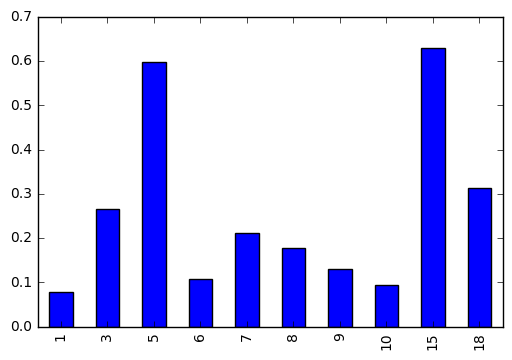

In [30]:
train_data01_merge_label_busi_type_code_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'BUSI_TYPE_CODE',split_by_tag=True,tag_name='TAG')

##### 3-7-1-2 测试集

In [26]:
# 当该字段为空情况下，有 0个工单
print test_data01_merge_label_df.loc[test_data01_merge_label_df['BUSI_TYPE_CODE'].isnull()].shape

(0, 15)


(10,)


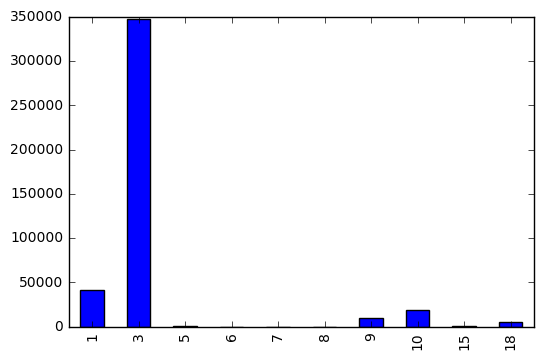

In [31]:
test_data01_merge_label_busi_type_code_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'BUSI_TYPE_CODE')

##### 3-7-1-3 合并结果

In [32]:
temp = train_data01_merge_label_busi_type_code_count_df.join(
    test_data01_merge_label_busi_type_code_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['BUSI_TYPE_CODE']
temp = temp.drop(labels = [u'BUSI_TYPE_CODE'],axis=1)
print '所有工单 - 业务类型编码 BUSI_TYPE_CODE'
print temp

所有工单 - 业务类型编码 BUSI_TYPE_CODE
      total    tag0  tag0/total    tag1  tag1/total  test_total
15     4286    1592    0.371442    2694    0.628558         506
5      2339     943    0.403164    1396    0.596836         762
18    12982    8923    0.687336    4059    0.312664        4857
3   1027793  753862    0.733476  273931    0.266524      347084
7        85      67    0.788235      18    0.211765          24
8       147     121    0.823129      26    0.176871          50
9     25230   21934    0.869362    3296    0.130638       10085
6       187     167    0.893048      20    0.106952          80
10    33498   30322    0.905188    3176    0.094812       18535
1     83651   77132    0.922069    6519    0.077931       41745


#### 3-7-2 代表工单下

##### 3-7-2-1 训练集

In [33]:
# 当该字段为空情况下，有 0个工单
print train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['BUSI_TYPE_CODE'].isnull()].shape

(0, 16)


(10, 5)


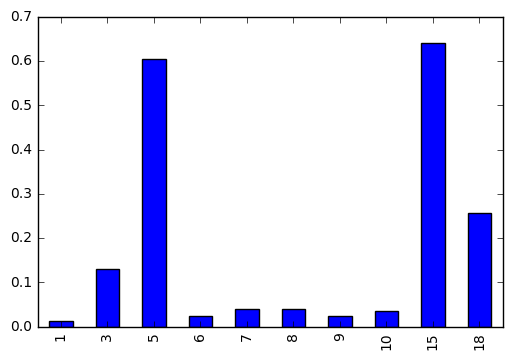

In [39]:
# 当该字段为不空情况下
train_data01_a_worker_per_user_busi_type_code_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'BUSI_TYPE_CODE',split_by_tag=True,tag_name='TAG')

##### 3-7-2-2 测试集

In [35]:
# 当该字段为空情况下，有 0个工单
print test_data01_a_worker_per_user.loc[test_data01_a_worker_per_user['BUSI_TYPE_CODE'].isnull()].shape

(0, 15)


(10,)


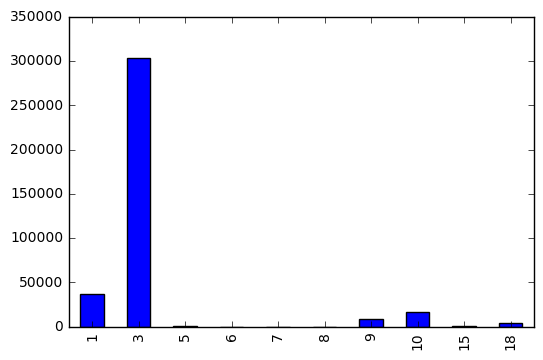

In [40]:
test_data01_a_worker_per_user_busi_type_code_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'BUSI_TYPE_CODE')

##### 3-7-2-3 合并结果

In [41]:
temp = train_data01_a_worker_per_user_busi_type_code_count_df.join(
    test_data01_a_worker_per_user_busi_type_code_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['BUSI_TYPE_CODE']
temp = temp.drop(labels = [u'BUSI_TYPE_CODE'],axis=1)
print '代表工单 -业务类型编码 BUSI_TYPE_CODE'
print temp

代表工单 -业务类型编码 BUSI_TYPE_CODE
     total    tag0  tag0/total   tag1  tag1/total  test_total
15    3456    1245    0.360243   2211    0.639757         455
5     1905     754    0.395801   1151    0.604199         724
18    7838    5834    0.744323   2004    0.255677        4231
3   560528  487620    0.869930  72908    0.130070      303447
7       49      47    0.959184      2    0.040816          24
8       75      72    0.960000      3    0.040000          40
10   23261   22451    0.965178    810    0.034822       16979
9    11771   11477    0.975023    294    0.024977        8242
6       82      80    0.975610      2    0.024390          74
1    49412   48772    0.987048    640    0.012952       36655


##### 业务类型编码 初步结论
- 类型    15、5（投诉）               可能有价值，因为 敏感度最高
- 类型    1（故障报修）、10（订阅信息）  可能有价值，因为 不敏感度最高


### 3-6 所属省（市）公司供电单位编码 PROV_ORG_NO

In [ ]:
show_attribute_detail(data01_train_merge_label_df,'PROV_ORG_NO',split_by_tag=True,tag_name='TAG')

In [ ]:
len(data01_train_merge_label_df['PROV_ORG_NO'].unique())

###### 小结
- 所有工单都是一个单位编号，价值不大

### 3-7 所属市（区）公司供电单位编码 CITY_ORG_NO

#### 3-7-1所有工单下

#### 3-7-1-1 训练集

In [80]:
# 当该字段为空情况下，有 0个工单
print train_data01_merge_label_df.loc[train_data01_merge_label_df['CITY_ORG_NO'].isnull()].shape

(0, 16)


In [ ]:
show_attribute_detail(data01_train_merge_label_df,'CITY_ORG_NO',split_by_tag=True,tag_name='TAG')

In [ ]:
len(data01_train_merge_label_df['CITY_ORG_NO'].unique())

(12, 5)


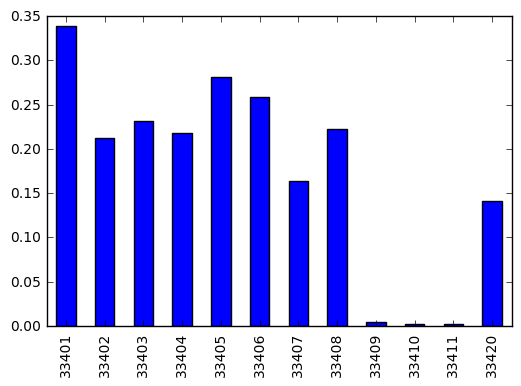

In [81]:
train_data01_merge_label_city_org_no_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'CITY_ORG_NO',split_by_tag=True,tag_name='TAG')

##### 3-7-1-2 测试集

In [82]:
# 当该字段为空情况下，有 0个工单
print test_data01_merge_label_df.loc[test_data01_merge_label_df['CITY_ORG_NO'].isnull()].shape

(0, 15)


(12,)


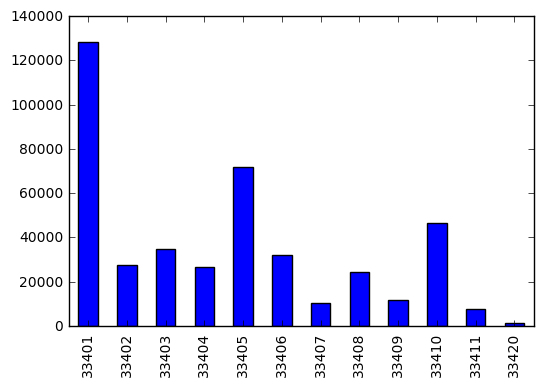

In [83]:
test_data01_merge_label_city_org_no_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'CITY_ORG_NO')

##### 3-7-1-3 合并结果

In [86]:
temp = train_data01_merge_label_city_org_no_count_df.join(
    test_data01_merge_label_city_org_no_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['CITY_ORG_NO']
temp = temp.drop(labels = [u'CITY_ORG_NO'],axis=1)
print '所有工单 - 所属市（区）公司供电单位编码 CITY_ORG_NO'
print temp

所有工单 - 所属市（区）公司供电单位编码 CITY_ORG_NO
        total    tag0  tag0/total    tag1  tag1/total  test_total
33401  432944  286104    0.660834  146840    0.339166      128475
33405  203431  146238    0.718858   57193    0.281142       71736
33406   84775   62893    0.741881   21882    0.258119       32190
33403   86659   66633    0.768910   20026    0.231090       34724
33408   65184   50703    0.777844   14481    0.222156       24574
33404   67020   52413    0.782050   14607    0.217950       26752
33402   72912   57393    0.787154   15519    0.212846       27700
33407   21298   17806    0.836041    3492    0.163959       10360
33420    5237    4500    0.859271     737    0.140729        1451
33409   25903   25785    0.995445     118    0.004555       11754
33411   17842   17804    0.997870      38    0.002130        7689
33410  106993  106791    0.998112     202    0.001888       46323


#### 3-7-2 代表工单下

##### 3-7-2-1 训练集

In [101]:
# 当该字段为空情况下，有 0个工单
print train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['CITY_ORG_NO'].isnull()].shape

(0, 16)


(12, 5)


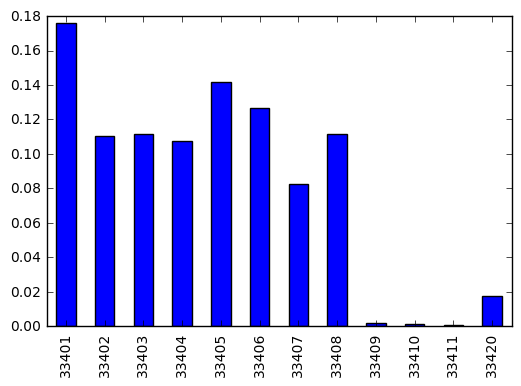

In [106]:
# 当该字段为不空情况下
train_data01_a_worker_per_user_city_org_no_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'CITY_ORG_NO',split_by_tag=True,tag_name='TAG')

##### 3-7-2-2 测试集

In [103]:
# 当该字段为空情况下，有 0个工单
print test_data01_a_worker_per_user.loc[test_data01_a_worker_per_user['CITY_ORG_NO'].isnull()].shape

(0, 15)


(12,)


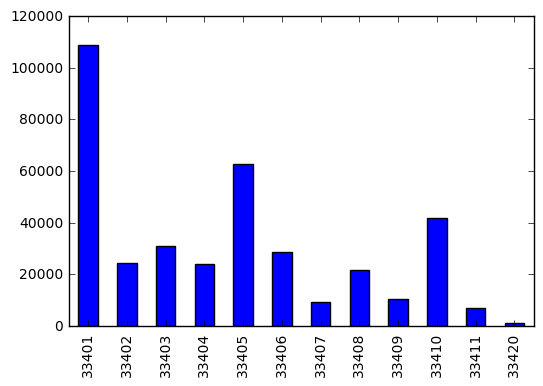

In [104]:
test_data01_a_worker_per_user_city_org_no_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'CITY_ORG_NO')

##### 3-7-2-3 合并结果

In [108]:
temp = train_data01_a_worker_per_user_city_org_no_count_df.join(
    test_data01_a_worker_per_user_city_org_no_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['CITY_ORG_NO']
temp = temp.drop(labels = [u'CITY_ORG_NO'],axis=1)
print '代表工单 -所属市（区）公司供电单位编码 CITY_ORG_NO'
print temp

代表工单 -所属市（区）公司供电单位编码 CITY_ORG_NO
        total    tag0  tag0/total   tag1  tag1/total  test_total
33401  213976  176303    0.823938  37673    0.176062      108752
33405  112184   96258    0.858037  15926    0.141963       62553
33406   48440   42314    0.873534   6126    0.126466       28622
33403   51437   45701    0.888485   5736    0.111515       30863
33408   38071   33826    0.888498   4245    0.111502       21720
33402   42215   37563    0.889802   4652    0.110198       24545
33404   40391   36062    0.892823   4329    0.107177       23953
33407   14672   13464    0.917666   1208    0.082334        9452
33420    1561    1534    0.982703     27    0.017297        1064
33409   16785   16758    0.998391     27    0.001609       10615
33410   67441   67375    0.999021     66    0.000979       41823
33411   11204   11194    0.999107     10    0.000893        6909


###### 小结
- 有价值
- 比如 33410、33409、33411 -- 显然都是不敏感用户的关键信息

### 3-8 受理意见 HANDLE_OPINION

In [ ]:
# 当该字段为空情况下
show_attribute_detail(
    data01_train_merge_label_df.loc[data01_train_merge_label_df['HANDLE_OPINION'].isnull()],
    attribute_name='TAG',
);

In [ ]:
# 数量比较多，导出分析
save_data(
    data01_train_merge_label_df.loc[data01_train_merge_label_df['HANDLE_OPINION'].notnull(),['HANDLE_OPINION','TAG']],
    'handle_opinion.csv'
)

###### 小结
- 经表格分析，没发现规律

### 3-9 受理时间 HANDLE_TIME

#### 3-9-1 所有工单下

#### 3-9-1-1 训练集

In [10]:
%%time
# 将受理时间进行编码，映射到 年 月 日 小时

# 时
train_data01_merge_label_df.loc[:,'HANDLE_HOUR'] = \
    train_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='hour'))
# 年
train_data01_merge_label_df.loc[:,'HANDLE_YEAR'] = \
    train_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='year'))
# 月
train_data01_merge_label_df.loc[:,'HANDLE_MONTH'] = \
    train_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='month'))
# 日
train_data01_merge_label_df.loc[:,'HANDLE_DAY'] = \
    train_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='day'))
print train_data01_merge_label_df.head()

             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280016584  1000000527201688               1               2.0   
1  2015101280016722  1000000527203612               3               2.0   
2  2015101280016734  1000000527203685               3               2.0   
3  2015101280019989  1000000527220221               3               1.0   
4  2015101280020073  1000000527220797               3               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340501  2015/10/12 7:27:08   
1    3341020  2015/10/12 7:31:50   
2    3340670  2015/10/12 7:32:03   
3    3340401  2015/10/12 8:04:42   
4  334010101  2015/10/12 8:06:05   

                                    ACCEPT_CONTENT HANDLE_OPINION  CALLING_NO  \
0  【一户无电】非居民客户报修一户无电，经指导客户检查，无法判断设备故障及其资产归属，请现场查处。            NaN   1625671.0   
1                                 【银行代扣】客户咨询银行代扣事宜            NaN   1196922.0   
2                            【查询电费】客户查询本月电费金额，已告知。            NaN   1378624.0   
3       

In [ ]:
show_attribute_detail(train_data01_merge_label_df,'HANDLE_HOUR',split_by_tag=True,tag_name='TAG')

In [ ]:
show_attribute_detail(train_data01_merge_label_df,'HANDLE_YEAR',split_by_tag=True,tag_name='TAG')

(12, 5)


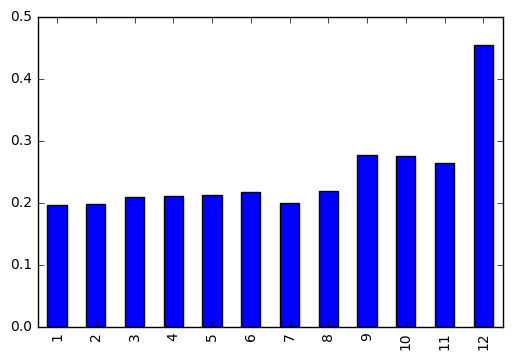

In [33]:
train_data01_merge_label_handle_month_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'HANDLE_MONTH',split_by_tag=True,tag_name='TAG')

In [ ]:
show_attribute_detail(data01_train_merge_label_df,'HANDLE_DAY',split_by_tag=True,tag_name='TAG')

##### 3-9-1-1-2 统计 每个用户的 出现在 第4季度（9-12） 的次数

In [17]:
train_data01_custno_handle_month_rdd = \
    sc.parallelize(train_data01_merge_label_df[['CUST_NO','HANDLE_MONTH']].as_matrix())
train_data01_custno_handle_month_rdd.cache()

ParallelCollectionRDD[6] at parallelize at PythonRDD.scala:475

In [18]:
%%time
train_custno_in_season4_count_rdd = train_data01_custno_handle_month_rdd.groupBy(lambda x:x[0]).mapValues(
    lambda items: sum([x[1]>=9 for x in items ])
)
train_custno_in_season4_count_dict = train_custno_in_season4_count_rdd.collectAsMap()

CPU times: user 448 ms, sys: 28 ms, total: 476 ms
Wall time: 16.4 s


In [54]:
len(train_custno_in_season4_count_dict) == 658374

True

##### 3-9-1-1-3 新增字段 NUM_OF_IN_SEASON4 标识 用户 第4季度（9-12） 的记录个数

In [19]:
train_data01_merge_label_df['NUM_OF_IN_SEASON4'] = \
    train_data01_merge_label_df['CUST_NO'].map(train_custno_in_season4_count_dict)

###### 3-9-1-1-4 统计

(31, 5)


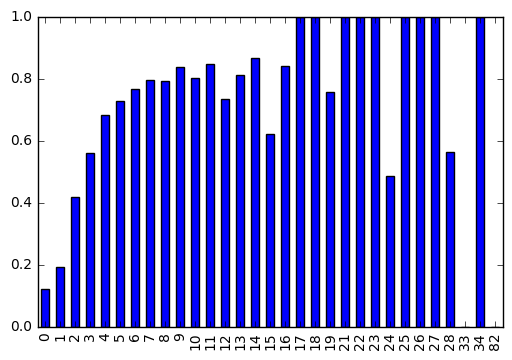

In [45]:
train_data01_merge_label_num_of_season4_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'NUM_OF_IN_SEASON4',split_by_tag=True,tag_name='TAG').sort_values(by='tag1/total',ascending=False)

In [49]:
save_data(
    train_data01_merge_label_df[train_data01_merge_label_df['TAG']==1][['APP_NO','CUST_NO','HANDLE_TIME','HANDLE_MONTH']].sort_values(by='CUST_NO')[:1000],
    'handle_time.csv'
)

#### 3-9-1-2 测试集

In [76]:
%%time
# 将受理时间进行编码，映射到 年 月 日 小时

# 时
test_data01_merge_label_df.loc[:,'HANDLE_HOUR'] = \
    test_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='hour'))
# 年
test_data01_merge_label_df.loc[:,'HANDLE_YEAR'] = \
    test_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='year'))
# 月
test_data01_merge_label_df.loc[:,'HANDLE_MONTH'] = \
    test_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='month'))
# 日
test_data01_merge_label_df.loc[:,'HANDLE_DAY'] = \
    test_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='day'))
print test_data01_merge_label_df.head()

             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280019632  1000000527215943               3               1.0   
1  2015101280019648  1000000527216033              10               2.0   
2  2015101280019680  1000000527216202               3               2.0   
3  2015101280019873  1000000527218491               3               1.0   
4  2015101280020130  1000000527221199               1               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340780  2015/10/12 7:58:04   
1  334066001  2015/10/12 7:58:26   
2    3340690  2015/10/12 7:58:52   
3    3340810  2015/10/12 8:02:53   
4    3340501  2015/10/12 8:07:10   

                                      ACCEPT_CONTENT HANDLE_OPINION  \
0   【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。            NaN   
1  【退订】#2061584501；【退订】#2061584602；【退订】#406091928...            NaN   
2                                【查询电费】客户查询本月电费，已告知。            NaN   
3                           【咨询总户号】通过地址、户名查询户号信息

(12,)


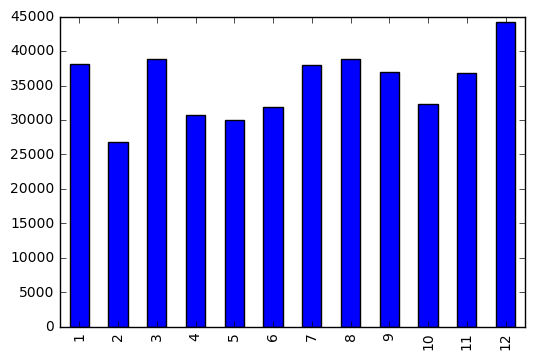

In [37]:
test_data01_merge_label_handle_month_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'HANDLE_MONTH')

##### 3-9-1-2-1 统计 每个用户的 出现在 第4季度（9-12） 的次数

In [45]:
test_data01_custno_handle_month_rdd = \
    sc.parallelize(test_data01_merge_label_df[['CUST_NO','HANDLE_MONTH']].as_matrix())
test_data01_custno_handle_month_rdd.cache()

ParallelCollectionRDD[24] at parallelize at PythonRDD.scala:475

In [46]:
%%time
test_custno_in_season4_count_rdd = test_data01_custno_handle_month_rdd.groupBy(lambda x:x[0]).mapValues(
    lambda items: sum([x[1]>=9 for x in items ])
)
test_custno_in_season4_count_dict = test_custno_in_season4_count_rdd.collectAsMap()

CPU times: user 312 ms, sys: 28 ms, total: 340 ms
Wall time: 8.17 s


In [62]:
len(test_custno_in_season4_count_dict)

370871

##### 3-9-1-2-3 新增字段 NUM_OF_IN_SEASON4 标识 用户 第4季度（9-12） 的记录个数

In [47]:
test_data01_merge_label_df['NUM_OF_IN_SEASON4'] = \
    test_data01_merge_label_df['CUST_NO'].map(test_custno_in_season4_count_dict)

(8,)


0    262157
1    135137
2     21165
3      4150
4       829
5       242
6        33
7        15
Name: NUM_OF_IN_SEASON4, dtype: int64

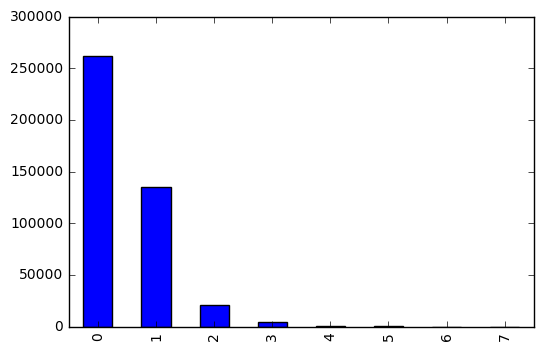

In [66]:
show_attribute_detail(test_data01_merge_label_df,'NUM_OF_IN_SEASON4')

(8,)


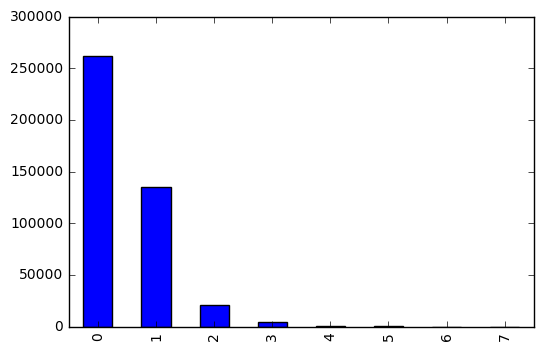

In [41]:
test_data01_merge_label_num_of_season4_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'NUM_OF_IN_SEASON4')

In [46]:
temp = train_data01_merge_label_num_of_season4_count_df.join(
    test_data01_merge_label_num_of_season4_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['NUM_OF_IN_SEASON4']
temp = temp.drop(labels = [u'NUM_OF_IN_SEASON4'],axis=1)
print '所有工单 -受理时间 NUM_OF_IN_SEASON4'
print temp

所有工单 -受理时间 NUM_OF_IN_SEASON4
     total      tag0  tag0/total     tag1  tag1/total  test_total
22      81       0.0    0.000000     81.0    1.000000         0.0
23      82       0.0    0.000000     82.0    1.000000         0.0
27     125       0.0    0.000000    125.0    1.000000         0.0
26      90       0.0    0.000000     90.0    1.000000         0.0
21      42       0.0    0.000000     42.0    1.000000         0.0
18     139       0.0    0.000000    139.0    1.000000         0.0
17     205       0.0    0.000000    205.0    1.000000         0.0
25      70       0.0    0.000000     70.0    1.000000         0.0
34      83       0.0    0.000000     83.0    1.000000         0.0
14     562      74.0    0.131673    488.0    0.868327         0.0
11    1535     235.0    0.153094   1300.0    0.846906         0.0
16     362      57.0    0.157459    305.0    0.842541         0.0
9     3149     510.0    0.161956   2639.0    0.838044         0.0
13     818     155.0    0.189487    663.0    0.

#### 3-9-2 代表工单下

#### 3-9-2-1 训练集

###### 3-9-2-1-1 月份统计

(12, 5)


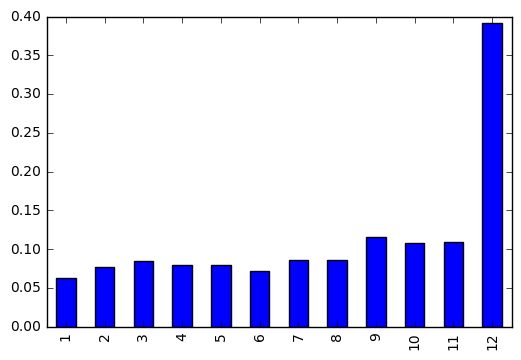

In [43]:
train_data01_a_worker_per_user_handle_month_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'HANDLE_MONTH',split_by_tag=True,tag_name='TAG')

###### 3-9-2-1-1 第4季度记录数统计

(31, 5)


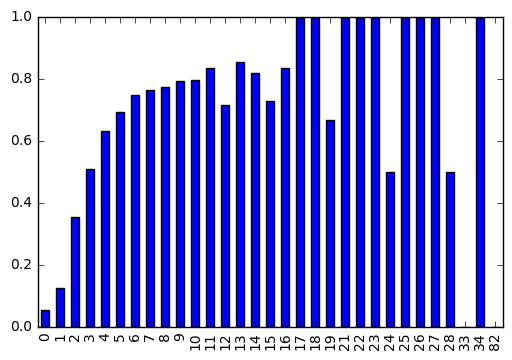

In [51]:
train_data01_a_worker_per_user_num_of_season4_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'NUM_OF_IN_SEASON4',split_by_tag=True,tag_name='TAG')

#### 3-9-2-2 测试集

###### 3-9-2-2-1 月份统计

(12,)


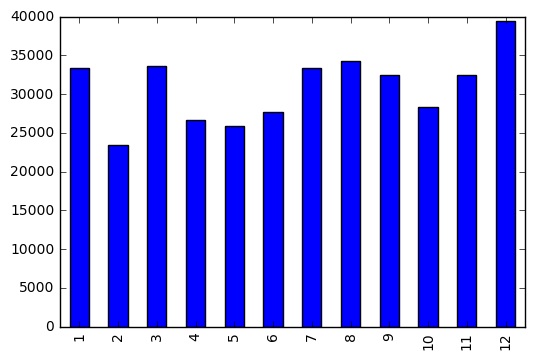

In [44]:
test_data01_a_worker_per_user_handle_month_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'HANDLE_MONTH')

###### 3-9-2-2-2 第4季度记录数统计

(8,)


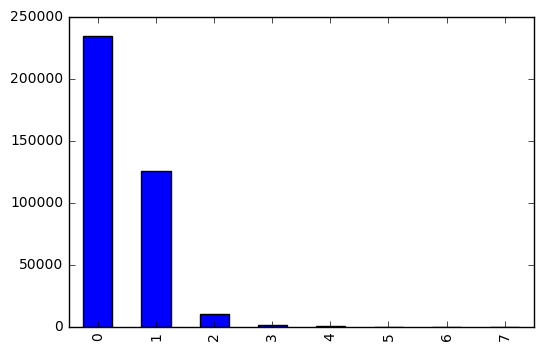

In [52]:
test_data01_a_worker_per_user_num_of_season4_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'NUM_OF_IN_SEASON4')

##### 3-9-2-3 合并结果

###### 3-9-2-3-1 月份统计

In [45]:
temp = train_data01_a_worker_per_user_handle_month_count_df.join(
    test_data01_a_worker_per_user_handle_month_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['HANDLE_MONTH']
temp = temp.drop(labels = [u'HANDLE_MONTH'],axis=1)
print '代表工单 -受理时间 HANDLE_TIME'
print temp

代表工单 -受理时间 HANDLE_TIME
    total   tag0  tag0/total   tag1  tag1/total  test_total
12  73884  44933    0.608156  28951    0.391844       39385
9   54781  48414    0.883774   6367    0.116226       32418
11  53990  48108    0.891054   5882    0.108946       32415
10  46807  41747    0.891897   5060    0.108103       28286
7   61924  56591    0.913878   5333    0.086122       33410
8   60301  55138    0.914380   5163    0.085620       34245
3   62724  57373    0.914690   5351    0.085310       33674
5   47590  43819    0.920761   3771    0.079239       25844
4   49081  45192    0.920764   3889    0.079236       26645
2   43026  39722    0.923209   3304    0.076791       23501
6   48162  44716    0.928450   3446    0.071550       27730
1   56107  52599    0.937477   3508    0.062523       33318


###### 3-9-2-2-2 第4季度记录数统计

In [53]:
temp = train_data01_a_worker_per_user_num_of_season4_count_df.join(
    test_data01_a_worker_per_user_num_of_season4_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['NUM_OF_IN_SEASON4']
temp = temp.drop(labels = [u'NUM_OF_IN_SEASON4'],axis=1)
print '代表工单 -受理时间 NUM_OF_IN_SEASON4'
print temp

代表工单 -受理时间 NUM_OF_IN_SEASON4
     total      tag0  tag0/total     tag1  tag1/total  test_total
17       8       0.0    0.000000      8.0    1.000000         0.0
22       2       0.0    0.000000      2.0    1.000000         0.0
27       3       0.0    0.000000      3.0    1.000000         0.0
26       3       0.0    0.000000      3.0    1.000000         0.0
25       1       0.0    0.000000      1.0    1.000000         0.0
23       2       0.0    0.000000      2.0    1.000000         0.0
21       1       0.0    0.000000      1.0    1.000000         0.0
34       1       0.0    0.000000      1.0    1.000000         0.0
18       4       0.0    0.000000      4.0    1.000000         0.0
13      34       5.0    0.147059     29.0    0.852941         0.0
11      85      14.0    0.164706     71.0    0.835294         0.0
16      12       2.0    0.166667     10.0    0.833333         0.0
14      22       4.0    0.181818     18.0    0.818182         0.0
10     123      25.0    0.203252     98.0    0.

###### 小结
- 全部数据都是 2015 年
- 第4季度的敏感度高很多，可能 HANDLE_MONTH 有价值
- 每天的数据都很均匀，没有多大价值

- 训练数据集上  月份的分布差异很大 ——> 所以可能月份是个非常重要的特征

### 3-10 城乡类别标志 URBAN_RURAL_FLAG

#### 3-10-1所有工单下

#### 3-10-1-1 训练集

(1004, 17)
(2,)


0    570
1     18
Name: TAG, dtype: int64

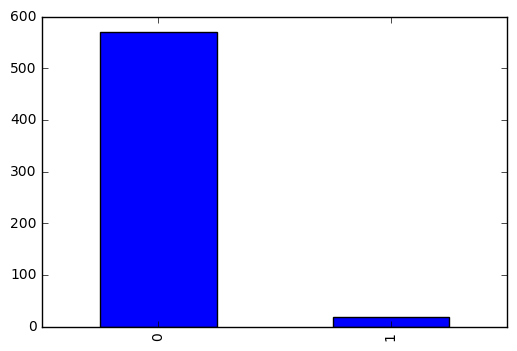

In [110]:
# 当该字段为空情况下，有 1004个工单，其中非敏感570,敏感 18
print train_data01_merge_label_df.loc[train_data01_merge_label_df['URBAN_RURAL_FLAG'].isnull()].shape
show_attribute_detail(
    train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['URBAN_RURAL_FLAG'].isnull()],
    attribute_name='TAG',
)

(3, 5)


,total,tag0,tag0/total,tag1,tag1/total
1.0,396883,343008,0.864255,53875,0.135745
2.0,259578,233488,0.899491,26090,0.100509
3.0,1328,1286,0.968373,42,0.031627


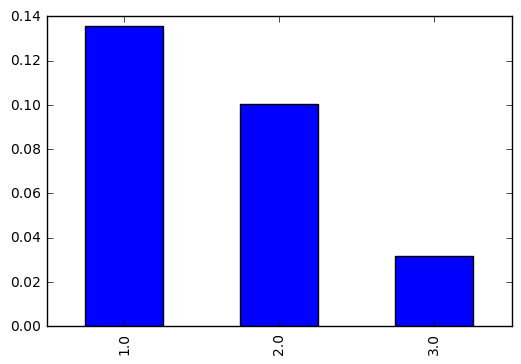

In [112]:
show_attribute_detail(train_data01_a_worker_per_user,'URBAN_RURAL_FLAG',split_by_tag=True,tag_name='TAG')

In [ ]:
len(data01_train_merge_label_df['URBAN_RURAL_FLAG'].unique())

(3, 5)


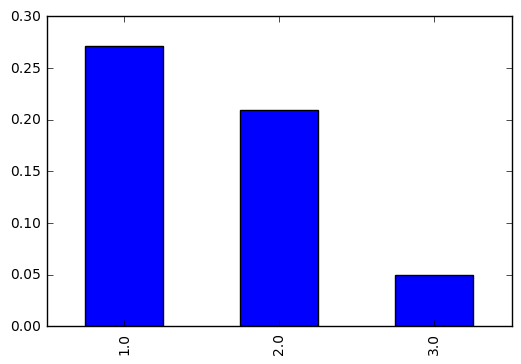

In [113]:
train_data01_merge_label_urban_rural_flag_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'URBAN_RURAL_FLAG',split_by_tag=True,tag_name='TAG')

##### 3-10-1-2 测试集

In [114]:
# 当该字段为空情况下，有 448个工单
print test_data01_merge_label_df.loc[test_data01_merge_label_df['URBAN_RURAL_FLAG'].isnull()].shape

(448, 15)


(3,)


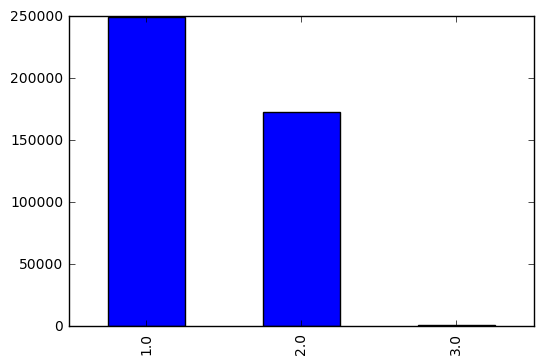

In [115]:
test_data01_merge_label_urban_rural_flag_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'URBAN_RURAL_FLAG')

##### 3-10-1-3 合并结果

In [118]:
temp = train_data01_merge_label_urban_rural_flag_count_df.join(
    test_data01_merge_label_urban_rural_flag_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['URBAN_RURAL_FLAG']
temp = temp.drop(labels = [u'URBAN_RURAL_FLAG'],axis=1)
print '所有工单 - 城乡类别标志 URBAN_RURAL_FLAG'
print temp

所有工单 - 城乡类别标志 URBAN_RURAL_FLAG
      total    tag0  tag0/total    tag1  tag1/total  test_total
1.0  745444  543091    0.728547  202353    0.271453      249416
2.0  441830  349262    0.790490   92568    0.209510      172920
3.0    1920    1824    0.950000      96    0.050000         944


#### 3-10-2 代表工单下

##### 3-10-2-1 训练集

(588, 16)
(2,)


0    570
1     18
Name: TAG, dtype: int64

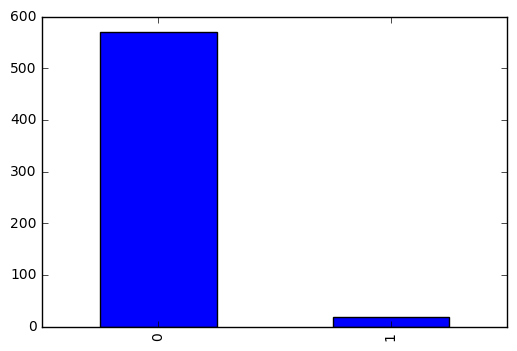

In [119]:
# 当该字段为空情况下，有 588个工单，不敏感570,敏感18
print train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['URBAN_RURAL_FLAG'].isnull()].shape
show_attribute_detail(
    train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['URBAN_RURAL_FLAG'].isnull()],
    attribute_name='TAG',
)

(3, 5)


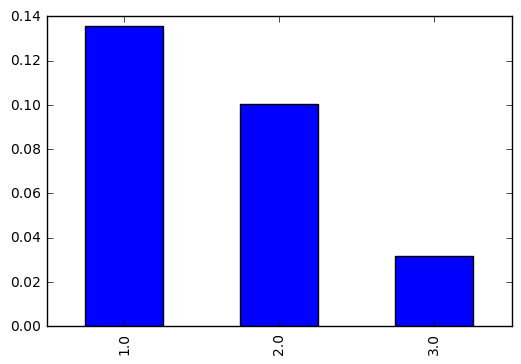

In [120]:
# 当该字段为不空情况下
train_data01_a_worker_per_user_urban_rural_flag_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'URBAN_RURAL_FLAG',split_by_tag=True,tag_name='TAG')

##### 3-10-2-2 测试集

In [121]:
# 当该字段为空情况下，有 401个工单
print test_data01_a_worker_per_user.loc[test_data01_a_worker_per_user['URBAN_RURAL_FLAG'].isnull()].shape

(401, 15)


(3,)


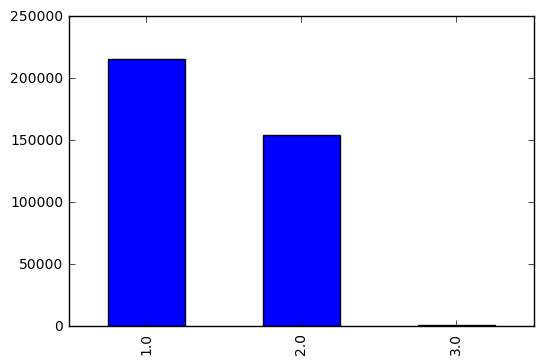

In [122]:
test_data01_a_worker_per_user_urban_rural_flag_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'URBAN_RURAL_FLAG')

##### 3-10-2-3 合并结果

In [123]:
temp = train_data01_a_worker_per_user_urban_rural_flag_count_df.join(
    test_data01_a_worker_per_user_urban_rural_flag_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['URBAN_RURAL_FLAG']
temp = temp.drop(labels = [u'URBAN_RURAL_FLAG'],axis=1)
print '代表工单 -城乡类别标志 URBAN_RURAL_FLAG'
print temp

代表工单 -城乡类别标志 URBAN_RURAL_FLAG
      total    tag0  tag0/total   tag1  tag1/total  test_total
1.0  396883  343008    0.864255  53875    0.135745      215343
2.0  259578  233488    0.899491  26090    0.100509      154263
3.0    1328    1286    0.968373     42    0.031627         864


###### 小结
- 类别3（特殊边远山区）  的敏感度最低 ， 有价值

### 3-11 用电类别 ELEC_TYPE

#### 3-11-1 所有工单下

##### 3-11-1-1 训练集

(254028, 16)
(2,)


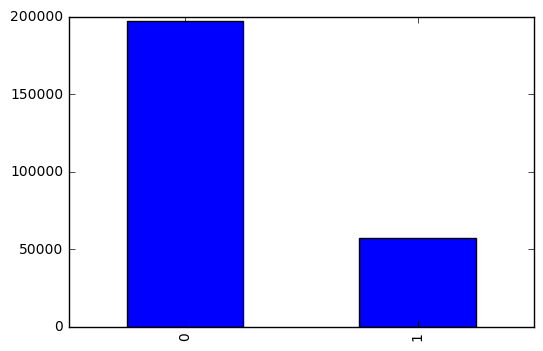

In [60]:
# 当该字段为空情况下，有 254028个工单，其中 196990个不敏感，57038个敏感
print train_data01_merge_label_df.loc[train_data01_merge_label_df['ELEC_TYPE'].isnull()].shape
show_attribute_detail(
    train_data01_merge_label_df.loc[train_data01_merge_label_df['ELEC_TYPE'].isnull()],
    attribute_name='TAG',
)

(19, 5)


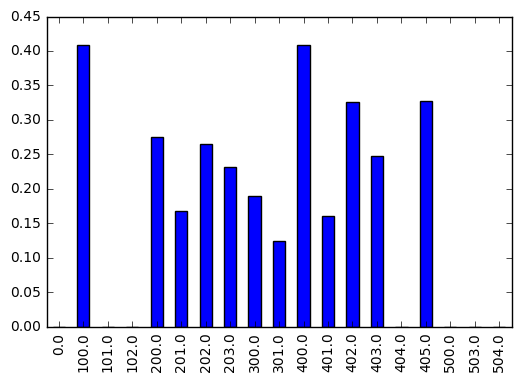

In [64]:
train_data01_merge_label_elec_type_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'ELEC_TYPE',split_by_tag=True,tag_name='TAG')

##### 3-11-1-2 测试集

In [58]:
# 当该字段为空情况下，有 89812个工单
print test_data01_merge_label_df.loc[test_data01_merge_label_df['ELEC_TYPE'].isnull()].shape

(89812, 15)


(18,)


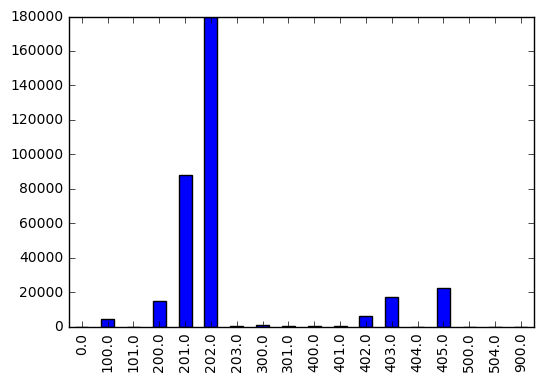

In [62]:
test_data01_merge_label_elec_type_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'ELEC_TYPE')

##### 3-11-1-3 合并结果

In [78]:
temp = train_data01_merge_label_elec_type_count_df.join(
    test_data01_merge_label_elec_type_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['ELEC_TYPE']
temp = temp.drop(labels = [u'ELEC_TYPE'],axis=1)
temp

,total,tag0,tag0/total,tag1,tag1/total,test_total
100.0,26773.0,15820.0,0.590894,10953.0,0.409106,4372.0
400.0,186.0,110.0,0.591398,76.0,0.408602,42.0
405.0,72102.0,48535.0,0.673144,23567.0,0.326856,22276.0
402.0,20667.0,13922.0,0.673634,6745.0,0.326366,5989.0
200.0,42112.0,30525.0,0.724853,11587.0,0.275147,14576.0
202.0,519338.0,381384.0,0.734366,137954.0,0.265634,179996.0
403.0,55050.0,41404.0,0.752116,13646.0,0.247884,17291.0
203.0,407.0,313.0,0.769042,94.0,0.230958,162.0
300.0,2483.0,2014.0,0.811116,469.0,0.188884,1099.0
201.0,196417.0,163493.0,0.832377,32924.0,0.167623,87808.0


#### 3-11-2 代表工单下

##### 3-11-2-1 训练集

(137439, 16)
(2,)


0    122466
1     14973
Name: TAG, dtype: int64

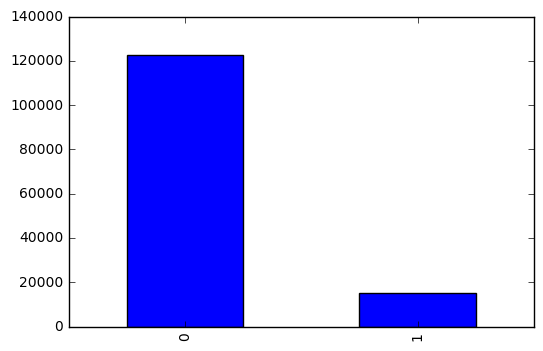

In [55]:
# 当该字段为空情况下，有 137439个工单，其中 122466个不敏感，14973个敏感
print train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['ELEC_TYPE'].isnull()].shape
show_attribute_detail(
    train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['ELEC_TYPE'].isnull()],
    attribute_name='TAG',
)

(19, 5)


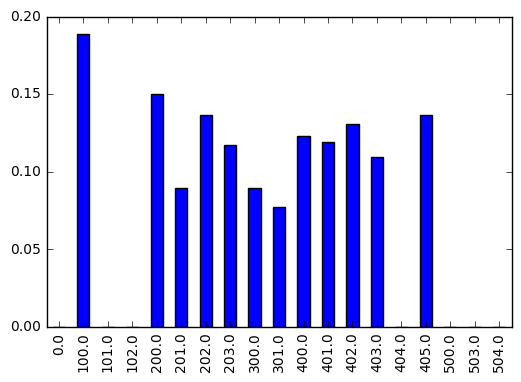

In [61]:
train_data01_a_worker_per_user_elec_type_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'ELEC_TYPE',split_by_tag=True,tag_name='TAG')

##### 3-11-2-2 测试集

In [95]:
# 当该字段为空情况下，有 78122个工单
print test_data01_a_worker_per_user.loc[test_data01_a_worker_per_user['ELEC_TYPE'].isnull()].shape

(78122, 15)


(18,)


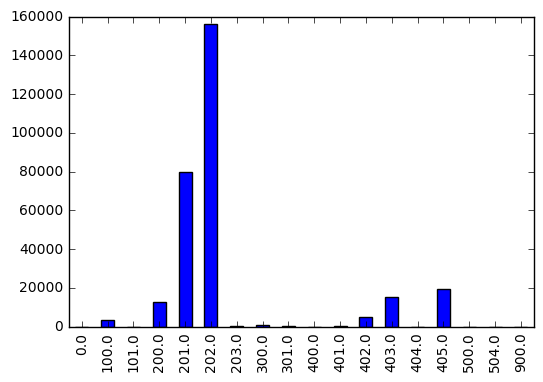

In [97]:
test_data01_a_worker_per_user_elec_type_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'ELEC_TYPE')

##### 3-11-2-3 合并结果

In [99]:
temp = train_data01_a_worker_per_user_elec_type_count_df.join(
    test_data01_a_worker_per_user_elec_type_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['ELEC_TYPE']
temp = temp.drop(labels = [u'ELEC_TYPE'],axis=1)
print '代表工单 -用电类别 ELEC_TYPE'
print temp

代表工单 -用电类别 ELEC_TYPE
          total      tag0  tag0/total     tag1  tag1/total  test_total
100.0    8532.0    6920.0    0.811064   1612.0    0.188936      3459.0
200.0   23228.0   19742.0    0.849923   3486.0    0.150077     12597.0
202.0  286239.0  247094.0    0.863244  39145.0    0.136756    155912.0
405.0   35136.0   30342.0    0.863559   4794.0    0.136441     19418.0
402.0    9640.0    8379.0    0.869191   1261.0    0.130809      5174.0
400.0      65.0      57.0    0.876923      8.0    0.123077        34.0
401.0      84.0      74.0    0.880952     10.0    0.119048        47.0
203.0     239.0     211.0    0.882845     28.0    0.117155       143.0
403.0   28267.0   25171.0    0.890473   3096.0    0.109527     15188.0
201.0  127640.0  116190.0    0.910295  11450.0    0.089705     79539.0
300.0    1506.0    1371.0    0.910359    135.0    0.089641       995.0
301.0     351.0     324.0    0.923077     27.0    0.076923       234.0
504.0       4.0       4.0    1.000000      0.0    0.0000

###### 小结
- 工业性的用电 敏感度高，比如 400（一般工商业）、100（大工业用电）、405（商业用电）、402（非工业）

### 3-15 CUST_NO前缀

In [ ]:
%%time
train_data01_a_worker_per_user['CUST_NO_3bit'] = train_data01_a_worker_per_user['CUST_NO'].str.slice(0,3)

In [ ]:
test_data01_a_worker_per_user = test_data01_a_worker_per_user.drop(['CUST_NO_8bit'],axis=1)

In [ ]:
%%time
test_data01_a_worker_per_user['CUST_NO_3bit'] = test_data01_a_worker_per_user['CUST_NO'].str.slice(0,3)

In [ ]:
len(train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1]['CUST_NO_8bit'].unique())

In [ ]:
train = show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'CUST_NO_8bit',
    True,
    'TAG',
    False
)


In [ ]:
test = show_attribute_detail(
    test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'CUST_NO_8bit',
    False,
    'TAG',
    False
)


In [1]:
temp = train.join(test,how='outer')

save_data(temp,'temp.csv',index=True)

NameError: name 'train' is not defined

### 3-16 ACCEPT_CONTENT_TYPE 取该用户所有记录工单

In [17]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['CUST_NO']=='0003408243']

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,NUM_OF_USED_PAY_MODE,IS_PAY_MODE_CONTAINS_020311,IS_PAY_MODE_CONTAINS_010101,IS_PAY_MODE_CONTAINS_020261,LAST_MONTH_PAY_MODE,PAY_MODE_CHANGE_CLUE,CUST_NO_3bit,ORG_NO_9bit,LAST_MONTH_PAY_MODE_4bit,PAY_MODE_4bit_CHANGE_CLUE
368850,2015010938116641,1000000240224233,3,1.0,3340201,2015/1/9 13:19:54,【信息咨询】客户来电反映0003408243户号有错发的短信,NaN,1754801.0,NaN,...,NaN,NaN,NaN,NaN,,NaN,000,NaN,,NaN


In [19]:
train_data01_merge_label_df[train_data01_merge_label_df['CUST_NO']=='0003408243']

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,CUST_NO,PROV_ORG_NO,CITY_ORG_NO,TAG,ACCEPT_CONTENT_TYPE
650686,2015010938116641,1000000240224233,3,1.0,3340201,2015/1/9 13:19:54,【信息咨询】客户来电反映0003408243户号有错发的短信,NaN,1754801.0,NaN,0003408243,33101,33402,0,信息咨询
651331,2015010938117991,1000000240230826,3,1.0,3340201,2015/1/9 13:26:44,【非电力维护】贵州用户,NaN,1754801.0,NaN,0003408243,33101,33402,0,非电力维护


#### 训练集

In [13]:
%%time
train_data01_cust_no_mulit_accept_content_type_series = \
    train_data01_merge_label_df.groupby('CUST_NO')['ACCEPT_CONTENT_TYPE'].apply(
        lambda x:'+'.join( [item for item in set(x) if item is not None])
    )

CPU times: user 36.6 s, sys: 192 ms, total: 36.8 s
Wall time: 36.6 s


In [16]:
train_data01_cust_no_mulit_accept_content_type_series.head()

CUST_NO
00000248                       咨询总户号
0000048308                      重复缴费
0000320298                     咨询总户号
0000381811                      查询电费
0000506327                      缴费方式
0000656849                      缴费方式
00010005573702                 咨询总户号
0001649967                      异常来电
0002164407                      银行代扣
0002471802                      查询电费
0002471815                 信息咨询+抄表示数
0002476706               查询电费+欠费复电登记
0002496069                      一户无电
0002506278                咨询总户号+查询电费
0002507444                咨询总户号+用户信息
0002516497                     咨询总户号
0002557351                      查询电费
0002576549                     咨询总户号
0002581705                     咨询总户号
0002581851                     咨询总户号
0002581877                      用户信息
0002581949                 新增订阅+短信变更
0002582056        客户咨询一户无电+查询电费+一户无电
0002582098                     咨询总户号
0002582160                      查询电费
0002582199                     咨询总户号
0002582232               查询电费+

In [21]:
train_data01_a_worker_per_user['MULIT_ACCEPT_CONTENT_TYPE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data01_cust_no_mulit_accept_content_type_series)

#### 测试集

In [20]:
%%time
test_data01_cust_no_mulit_accept_content_type_series = \
    test_data01_merge_label_df.groupby('CUST_NO')['ACCEPT_CONTENT_TYPE'].apply(
        lambda x:'+'.join( [item for item in set(x) if item is not None])
    )

CPU times: user 20.9 s, sys: 80 ms, total: 21 s
Wall time: 20.9 s


In [22]:
test_data01_a_worker_per_user['MULIT_ACCEPT_CONTENT_TYPE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data01_cust_no_mulit_accept_content_type_series)

In [23]:
test_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_PAY_MODE_CONTAINS_020311,IS_PAY_MODE_CONTAINS_010101,IS_PAY_MODE_CONTAINS_020261,LAST_MONTH_PAY_MODE,PAY_MODE_CHANGE_CLUE,CUST_NO_3bit,ORG_NO_9bit,LAST_MONTH_PAY_MODE_4bit,PAY_MODE_4bit_CHANGE_CLUE,MULIT_ACCEPT_CONTENT_TYPE
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,...,1.0,1.0,0.0,010101,020311-010101,940,334078001,0101,0203-0101,客户咨询一户无电
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,...,1.0,0.0,0.0,020311,020311,685,334066001,0203,0203,退订
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,...,1.0,0.0,0.0,020311,020311,731,334069001,0203,0203,查询电费+回呼电话
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,...,0.0,1.0,0.0,010101,010101,333,334080101,0101,0101,咨询总户号
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,...,NaN,NaN,NaN,,NaN,521,NaN,,NaN,设备故障


------
## 4 数据缓存和恢复

### 4-1 保存

In [64]:
train_data01_a_worker_per_user.shape,test_data01_a_worker_per_user.shape

((658374, 54), (370871, 53))

#### 4-1-1 训练集

In [62]:
train_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,ORG_NO_7bit,AVERAGE_RCVBL_AMT,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE,MAX_NUM_MONTH_SEARCH_ACTION,NUM_OF_USED_PAY_MODE,IS_PAY_MODE_CONTAINS_020311,IS_PAY_MODE_CONTAINS_010101,IS_PAY_MODE_CONTAINS_020261
0,2015101280016722,1000000527203612,3,2.0,3341020,2015/10/12 7:31:50,【银行代扣】客户咨询银行代扣事宜,NaN,1196922.0,202.0,...,NaN,NaN,2.0,0,NaN,0.0,NaN,NaN,NaN,NaN
1,2015101280031388,1000000527304861,3,1.0,3340901,2015/10/12 9:14:03,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1005636.0,NaN,...,NaN,NaN,2.0,0,NaN,0.0,NaN,NaN,NaN,NaN
2,2015101280031424,1000000527305097,3,2.0,33401,2015/10/12 9:14:16,【查询电费】客户查询电费，已告知。,NaN,1007513.0,405.0,...,3340101.0,1652.304167,0.0,0,NaN,3.0,1.0,0.0,0.0,0.0
3,2015101280031680,1000000527300870,3,2.0,334020106,2015/10/12 9:11:37,【咨询总户号】通过地址（户名）查询户号信息。,NaN,1073266.0,202.0,...,3340201.0,51.961667,0.0,0,NaN,0.0,1.0,0.0,0.0,0.0
4,2015101280032506,1000000527305664,3,1.0,3340101,2015/10/12 9:14:48,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1433592.0,NaN,...,3340150.0,121.936250,0.0,0,NaN,0.0,1.0,1.0,0.0,0.0


In [25]:
%%time
%store train_data01_a_worker_per_user

Stored 'train_data01_a_worker_per_user' (DataFrame)
CPU times: user 4.81 s, sys: 1.26 s, total: 6.07 s
Wall time: 6.4 s


#### 4-1-2 测试集

In [89]:
test_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,NUM_OF_RCVBL_PENALTY,IS_CONNECT_TO_07TABLE,CONS_STATUS,RCA_FLAG,ORG_NO_7bit,AVERAGE_RCVBL_AMT,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE,MAX_NUM_MONTH_SEARCH_ACTION
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,...,0.0,0,NaN,NaN,3340780.0,68.573333,0.0,0,NaN,0.0
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,...,0.0,0,NaN,NaN,3340660.0,34.745833,0.0,0,NaN,0.0
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,...,0.0,0,NaN,NaN,3340690.0,207.431667,0.0,0,NaN,1.0
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,...,0.0,0,NaN,NaN,3340801.0,20.694444,0.0,0,NaN,0.0
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,...,NaN,0,NaN,NaN,NaN,NaN,2.0,0,NaN,0.0


In [26]:
%%time
%store test_data01_a_worker_per_user

Stored 'test_data01_a_worker_per_user' (DataFrame)
CPU times: user 2.46 s, sys: 384 ms, total: 2.84 s
Wall time: 3.08 s
